# PPP2R1A
[Houge-Janssens syndrome-2 (HJS2)](https://omim.org/entry/616362) is caused by heterozygous mutation in the PPP2R1A gene.

In [1]:
import gpsea
import hpotk
store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2025-01-16
Using gpsea version 0.9.4


# PPP2R1A
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for PPP2R1A.

In [2]:
from gpsea.preprocessing import configure_default_protein_metadata_service
gene_symbol = "PPP2R1A"
mane_tx_id = 'NM_014225.6'
mane_protein_id = "NP_055040.2"
pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

cohort_name = gene_symbol
phenopacket_store_release = '0.1.24'

registry = configure_phenopacket_registry()
with registry.open_phenopacket_store(phenopacket_store_release) as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(cohort_name))

cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)
del phenopackets
validation.summarize()

Individuals Processed: 100%|██████████| 60/60 [00:00<00:00, 2161.85 individuals/s]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer

viewer = CohortViewer(hpo)
viewer.process(cohort=cohort, transcript_id=mane_tx_id)

n,HPO Term
42,Hypotonia
31,Delayed speech and language development
31,Feeding difficulties
29,Motor delay
24,Seizure
21,Agenesis of corpus callosum
20,Microcephaly
17,Global developmental delay
17,"Intellectual disability, severe"
16,"Intellectual disability, moderate"


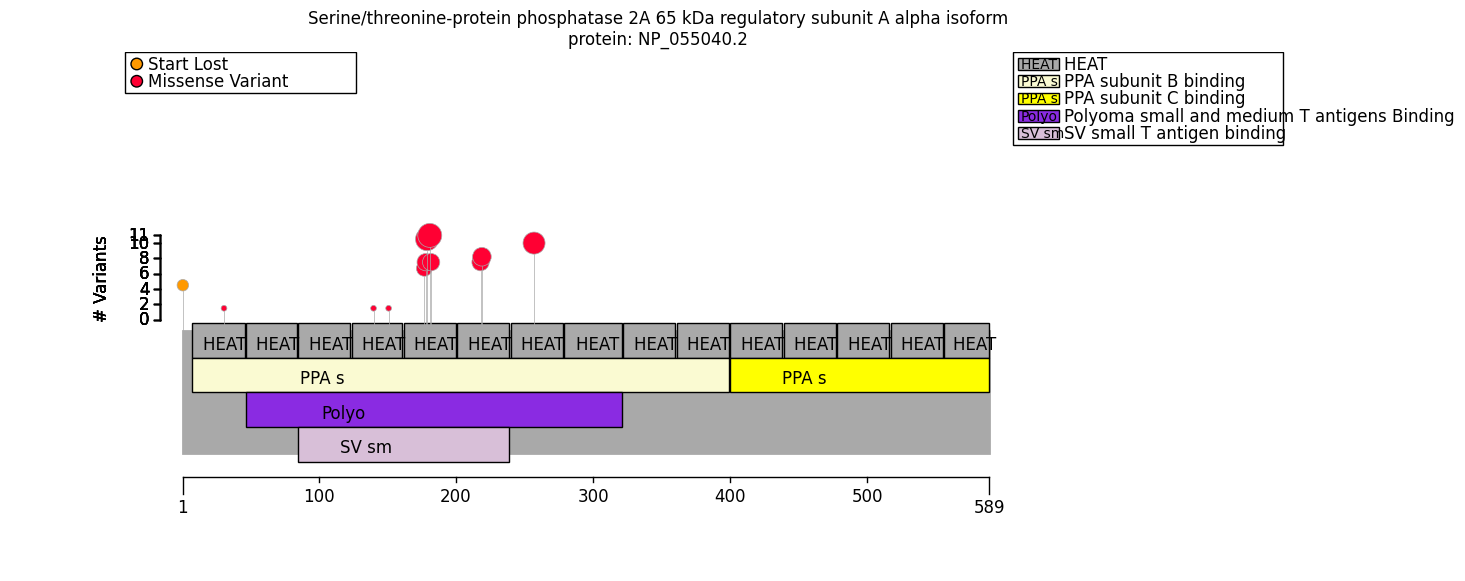

In [5]:
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

ppp2ra1_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein(
    protein_metadata=protein_meta,
    cohort=cohort,
    ax=ax,
)
ppp2ra1_fig.tight_layout()

In [6]:
from gpsea.view import ProteinVariantViewer
cpd_viewer = ProteinVariantViewer(tx_id=mane_tx_id, protein_metadata=protein_meta)
cpd_viewer.process(cohort)

Count,Name,Type,Coordinates,Variants
1,HEAT 1,Repeat,9 - 46,p.Ile32Met
58,PP2A subunit B binding,Region,9 - 399,p.Ile32Met; p.Ser219Leu; p.Met180Val; p.Val220Met; p.Met180Lys; p.Arg258His; p.Ser152Phe; p.Thr178Ser; p.Arg183Gln; p.Pro179His; p.Phe141Ile; p.Arg182Trp; p.Met180Arg; p.Arg183Trp; p.Arg258Ser; p.Pro179Leu; p.Thr178Asn; p.Met180Thr
0,HEAT 2,Repeat,48 - 84,
57,Polyoma small and medium T antigens Binding,Region,48 - 321,p.Ser219Leu; p.Met180Val; p.Val220Met; p.Met180Lys; p.Arg258His; p.Ser152Phe; p.Thr178Ser; p.Arg183Gln; p.Pro179His; p.Phe141Ile; p.Arg182Trp; p.Met180Arg; p.Arg183Trp; p.Arg258Ser; p.Pro179Leu; p.Thr178Asn; p.Met180Thr
0,HEAT 3,Repeat,86 - 123,
48,SV40 small T antigen binding,Region,86 - 239,p.Ser219Leu; p.Met180Val; p.Val220Met; p.Met180Lys; p.Ser152Phe; p.Thr178Ser; p.Arg183Gln; p.Pro179His; p.Phe141Ile; p.Arg182Trp; p.Met180Arg; p.Arg183Trp; p.Pro179Leu; p.Thr178Asn; p.Met180Thr
2,HEAT 4,Repeat,125 - 161,p.Phe141Ile; p.Ser152Phe
35,HEAT 5,Repeat,163 - 200,p.Met180Val; p.Met180Lys; p.Thr178Ser; p.Arg183Gln; p.Pro179His; p.Met180Arg; p.Arg182Trp; p.Arg183Trp; p.Pro179Leu; p.Thr178Asn; p.Met180Thr
11,HEAT 6,Repeat,202 - 239,p.Ser219Leu; p.Val220Met
9,HEAT 7,Repeat,241 - 278,p.Arg258Ser; p.Arg258His


In [7]:
from gpsea.view import CohortVariantViewer
cvv = CohortVariantViewer(tx_id=mane_tx_id)
cvv.process(cohort=cohort)

Count,Variant key,HGVS,Overlapping Exons,Effects
11,19_52212726_52212726_C_T,c.544C>T (p.Arg182Trp),5,missense
7,19_52213076_52213076_G_A,c.773G>A (p.Arg258His),6,missense
6,19_52212961_52212961_G_A,c.658G>A (p.Val220Met),6,missense
5,19_52212959_52212959_C_T,c.656C>T (p.Ser219Leu),6,missense
5,19_52212721_52212721_T_C,c.539T>C (p.Met180Thr),5,missense
3,19_52212720_52212720_A_G,c.538A>G (p.Met180Val),5,missense
3,19_52212718_52212718_C_T,c.536C>T (p.Pro179Leu),5,missense
3,19_52212730_52212730_G_A,c.548G>A (p.Arg183Gln),5,missense
2,19_52213075_52213075_C_A,c.772C>A (p.Arg258Ser),6,missense
2,19_52212718_52212718_C_A,c.536C>A (p.Pro179His),5,missense


# Genotype-Phenotype Correlation (GPC) Analysis
[Qian et al. (2023)](https://pubmed.ncbi.nlm.nih.gov/37761890/) concluded

> One subgroup of variants (p.Phe141Ile, p.Thr178Asn, p.Met180Val/Thr/Lys; absent from COSMIC) presented overall with a milder biochemical and clinical phenotype, while another subgroup (p.Pro179Arg, p.Arg182Trp, p.Arg183Trp, p.Ser291Leu, p.Val220Met, p.Arg258His/Ser; all with affected amino acids present in COSMIC) was overall more severely affected, both biochemically and phenotypically. 

In [8]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest

analysis = configure_hpo_term_analysis(hpo)
pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [9]:
from gpsea.analysis.predicate import variant_key, anyof
from gpsea.analysis.clf import monoallelic_classifier
from gpsea.view import MtcStatsViewer


phe141ile = variant_key("19_52211410_52211410_T_A") # c.421T>A	p.Phe141Ile 
thr178asn = variant_key("19_52212715_52212715_C_A") # c.533C>A	p.Thr178Asn
met180lys = variant_key("19_52212721_52212721_T_A") # c.539T>A	p.Met180Lys	
met180val = variant_key("19_52212720_52212720_A_G") # c.538A>G	p.Met180Val	
met180thr = variant_key("19_52212721_52212721_T_C") # c.539T>C	p.Met180Thr	

absent_in_cosmic = anyof((phe141ile, thr178asn, met180lys, met180thr, met180val))


arg182trp = variant_key("19_52212726_52212726_C_T") # c.544C>T	p.Arg182Trp	
arg183trp = variant_key("19_52212729_52212729_C_T") # c.547C>T	p.Arg183Trp
ser291leu = variant_key("19_52212959_52212959_C_T") # c.656C>T	p.Ser219Leu
val220met = variant_key("19_52212961_52212961_G_A") # c.658G>A	p.Val220Met
arg258his = variant_key("19_52213076_52213076_G_A") #	c.773G>A	p.Arg258His
arg258ser = variant_key("19_52213075_52213075_C_A") #	c.772C>A	p.Arg258Ser
p179l = variant_key("19_52212718_52212718_C_T") # c.536C>T	p.Pro179Leu
p179h = variant_key("19_52212718_52212718_C_A") # c.536C>A	p.Pro179His

present_in_cosmic = anyof((arg182trp, arg183trp, ser291leu, val220met, arg258his, arg258ser, p179h, p179l))

cosmic_clf = monoallelic_classifier(
    a_predicate=absent_in_cosmic,
    b_predicate=present_in_cosmic,
    a_label="Absent in COSMIC",
    b_label="Present in COSMIC"
)
cosmic_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=cosmic_clf,
    pheno_clfs=pheno_clfs,
)

viewer = MtcStatsViewer()
viewer.process(cosmic_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,12
HMF03,Skipping term because of a child term with the same individual counts,9
HMF08,Skipping general term,35
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,100


In [10]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=cosmic_result)

Allele group,Absent in COSMIC,Present in COSMIC,Corrected p values,p values
Aplasia/Hypoplasia of the corpus callosum [HP:0007370],1/1 (100%),34/34 (100%),1.0,1.0
Aplasia/Hypoplasia of the cerebrum [HP:0007364],1/1 (100%),36/36 (100%),1.0,1.0
Aplasia/Hypoplasia involving the central nervous system [HP:0002977],1/1 (100%),36/36 (100%),1.0,1.0
Intellectual disability [HP:0001249],10/10 (100%),28/28 (100%),1.0,1.0
Hypotonia [HP:0001252],12/12 (100%),25/25 (100%),1.0,1.0
Neurodevelopmental abnormality [HP:0012759],12/12 (100%),35/35 (100%),1.0,1.0
Abnormal cerebral white matter morphology [HP:0002500],2/2 (100%),34/34 (100%),1.0,1.0
Morphological central nervous system abnormality [HP:0002011],2/2 (100%),37/37 (100%),1.0,1.0
Abnormal cerebral morphology [HP:0002060],2/2 (100%),37/37 (100%),1.0,1.0
Abnormal forebrain morphology [HP:0100547],2/2 (100%),37/37 (100%),1.0,1.0


In [11]:
is_r182w = variant_key("19_52212726_52212726_C_T") #c.544C>T; p.Arg182Trp

r182w_clf = monoallelic_classifier(a_predicate=is_r182w,
                                    b_predicate=~is_r182w,
                                    a_label="Arg182Trp",
                                    b_label="other")

r182w_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=r182w_clf,
    pheno_clfs=pheno_clfs,
)

summarize_hpo_analysis(hpo=hpo, result=r182w_result)

Allele group,Arg182Trp,other,Corrected p values,p values
Neurodevelopmental abnormality [HP:0012759],10/10 (100%),44/44 (100%),1.0,1.0
Aplasia/Hypoplasia of the corpus callosum [HP:0007370],11/11 (100%),26/26 (100%),1.0,1.0
Abnormal cerebral white matter morphology [HP:0002500],11/11 (100%),27/27 (100%),1.0,1.0
Aplasia/Hypoplasia of the cerebrum [HP:0007364],11/11 (100%),29/29 (100%),1.0,1.0
Aplasia/Hypoplasia involving the central nervous system [HP:0002977],11/11 (100%),29/29 (100%),1.0,1.0
Abnormal cerebral morphology [HP:0002060],11/11 (100%),31/31 (100%),1.0,1.0
Abnormal forebrain morphology [HP:0100547],11/11 (100%),31/31 (100%),1.0,1.0
Morphological central nervous system abnormality [HP:0002011],11/11 (100%),32/32 (100%),1.0,1.0
Abnormal brain morphology [HP:0012443],11/11 (100%),32/32 (100%),1.0,1.0
Abnormality of skull size [HP:0000240],3/3 (100%),30/30 (100%),1.0,1.0


In [12]:
from gpsea.analysis.predicate import protein_feature

sv40 = protein_feature(feature_id="SV40 small T antigen binding", protein_metadata=protein_meta)

sv40_clf = monoallelic_classifier(a_predicate=sv40,
                                    b_predicate=~sv40,
                                    a_label="SV40 small T antigen binding",
                                    b_label="other")

sv40_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=sv40_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=sv40_result)

Allele group,SV40 small T antigen binding,other,Corrected p values,p values
Seizure [HP:0001250],20/20 (100%),4/4 (100%),1.0,1.0
Abnormality of skull size [HP:0000240],23/23 (100%),10/10 (100%),1.0,1.0
Motor delay [HP:0001270],25/25 (100%),4/4 (100%),1.0,1.0
Abnormal axial skeleton morphology [HP:0009121],28/28 (100%),10/10 (100%),1.0,1.0
Feeding difficulties [HP:0011968],28/28 (100%),5/5 (100%),1.0,1.0
Delayed speech and language development [HP:0000750],28/28 (100%),7/7 (100%),1.0,1.0
Abnormal communication [HP:0034434],28/28 (100%),7/7 (100%),1.0,1.0
Aplasia/Hypoplasia of the corpus callosum [HP:0007370],30/30 (100%),7/7 (100%),1.0,1.0
Abnormal cerebral white matter morphology [HP:0002500],31/31 (100%),7/7 (100%),1.0,1.0
Aplasia/Hypoplasia of the cerebrum [HP:0007364],31/31 (100%),9/9 (100%),1.0,1.0


# Summary

In [13]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary


fet_results = (
    GPAnalysisResultSummary.from_multi(
        result=cosmic_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=r182w_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=sv40_result
    )
)

caption = "No statistically significant results identified."
report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=fet_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=caption)

In [14]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

Genotype (A),Genotype (B),Tests performed,Significant tests
Absent in COSMIC,Present in COSMIC,18,0
Genotype (A),Genotype (B),Tests performed,Significant tests
Arg182Trp,other,19,0
Genotype (A),Genotype (B),Tests performed,Significant tests
SV40 small T antigen binding,other,19,0


In [15]:
summarizer.process_latex(report=report, protein_fig=ppp2ra1_fig)

Figure saved to ../../supplement/img/PPP2R1A_protein_diagram-draft.pdf
Output to ../../supplement/tex/PPP2R1A_summary_draft.tex
